## A Predictive Modeling Study of Regime Shift Detection and Future Forecasting in Atmospheric CO

## Data Acquisition

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor



In [3]:
df = pd.read_csv('co2_mm_mlo.csv')

In [4]:
df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.71,314.44,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.69,-1,-9.99,-0.99
3,1958,6,1958.4548,317.27,315.15,-1,-9.99,-0.99
4,1958,7,1958.5370,315.87,315.20,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
801,2024,12,2024.9583,425.40,426.12,28,0.70,0.25
802,2025,1,2025.0417,426.65,426.34,29,0.62,0.22
803,2025,2,2025.1250,427.09,426.16,24,0.64,0.25
804,2025,3,2025.2083,428.15,426.67,27,1.13,0.42


## Data cleaning

In [5]:
df.rename(columns={'decimal date': 'decimal_date', 'average': 'co2'}, inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df = df[['co2']]
df['co2'].replace(-99.99, pd.NA, inplace=True)
df['co2'] = df['co2'].interpolate(method='time')
df = df.dropna()



/var/folders/zc/2tfcymgx7tdbmn9w3ld9_hgh0000gn/T/ipykernel_35533/2889806818.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['co2'].replace(-99.99, pd.NA, inplace=True)
/var/folders/zc/2tfcymgx7tdbmn9w3ld9_hgh0000gn/T/ipykernel_35533/2889806818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co2'].replace(-99.99, pd.NA, inplace=T

In [6]:
df

,co2
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.27
1958-07-01,315.87
...,...
2024-12-01,425.40
2025-01-01,426.65
2025-02-01,427.09


In [7]:
df.isnull().sum()

co2    0
dtype: int64

## Trend/Seasonality Analysis 


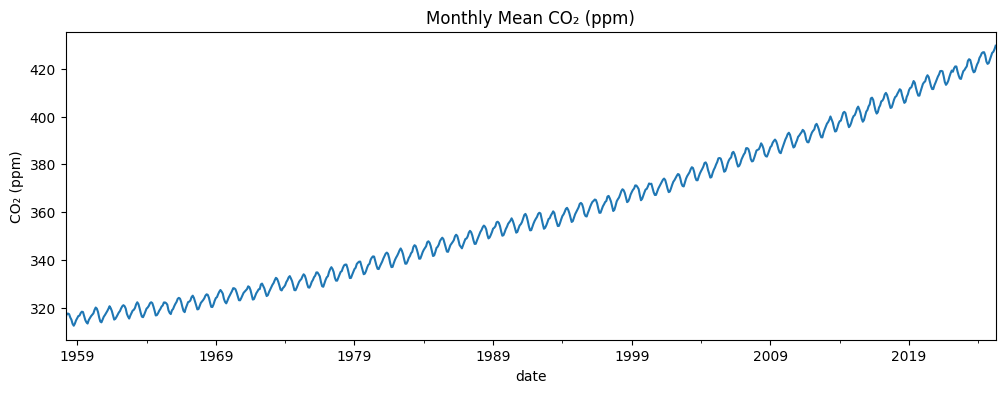

In [ ]:


df['co2'].plot(figsize=(12,4), title='Monthly Mean CO₂ (ppm)')
plt.ylabel('CO₂ (ppm)')
plt.show()




In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['co2'], model='additive', period=12)


In [10]:
trend = decomp.trend.dropna()
plt.figure(figsize=(12,5))
plt.plot(trend, label='Trend')
plt.title("Long-Term CO₂ Trend (Smoothed)")
plt.ylabel("CO₂ (ppm)")
plt.xlabel("Year")
plt.legend()
plt.show()


<Figure size 1200x500 with 1 Axes>

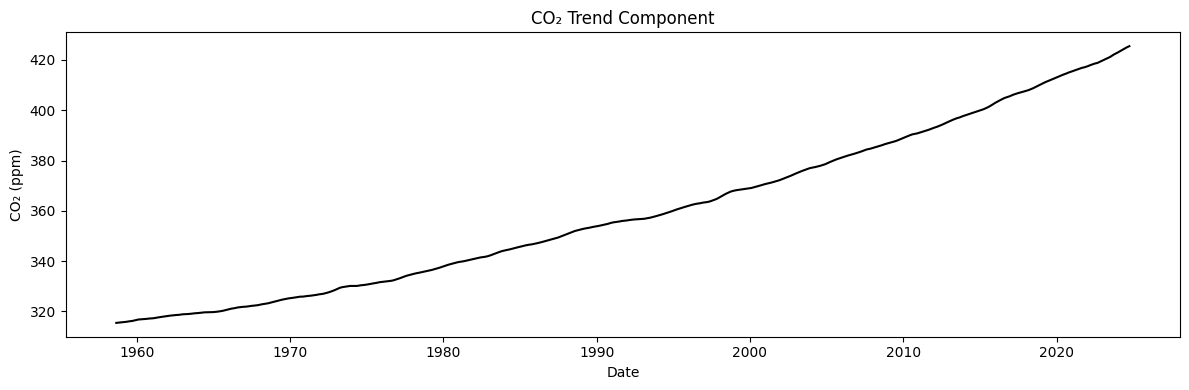

In [11]:
seasonal = decomp.seasonal
residual = decomp.resid.dropna()
# Trend
plt.figure(figsize=(12,4))
plt.plot(trend.index, trend.values, color='black')
plt.title("CO₂ Trend Component")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.tight_layout()
plt.show()

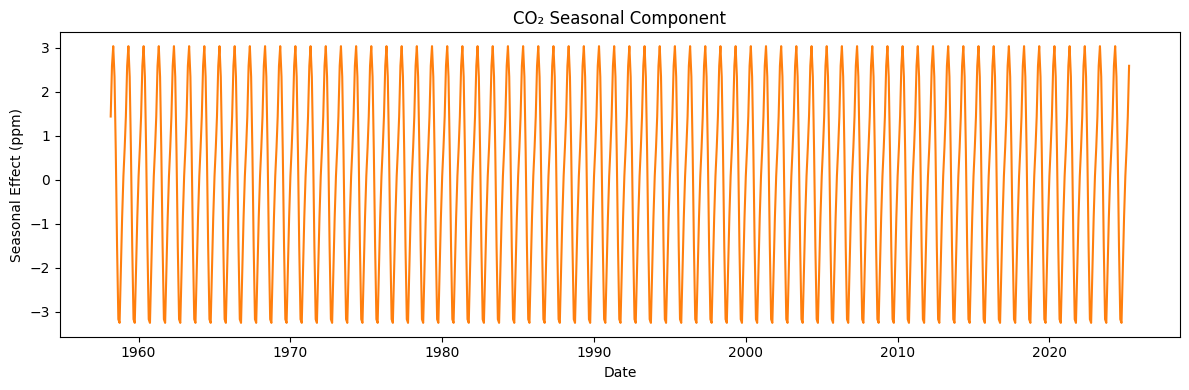

In [12]:
plt.figure(figsize=(12,4))
plt.plot(seasonal.index, seasonal.values, color='tab:orange')
plt.title("CO₂ Seasonal Component")
plt.xlabel("Date")
plt.ylabel("Seasonal Effect (ppm)")
plt.tight_layout()
plt.show()

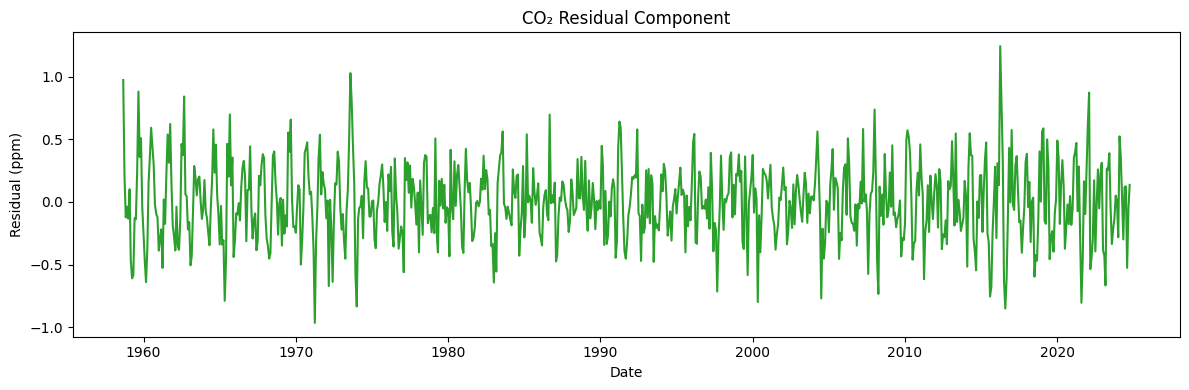

In [13]:
# Residual
plt.figure(figsize=(12,4))
plt.plot(residual.index, residual.values, color='tab:green')
plt.title("CO₂ Residual Component")
plt.xlabel("Date")
plt.ylabel("Residual (ppm)")
plt.tight_layout()
plt.show()

## Model Traning 

### Model train with Arima 

In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_order = (2, 1, 2)
arima_model = ARIMA(df['co2'], order=arima_order).fit()

arima_fitted = arima_model.fittedvalues

/Users/mdmahfuzurrahman/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mdmahfuzurrahman/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mdmahfuzurrahman/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


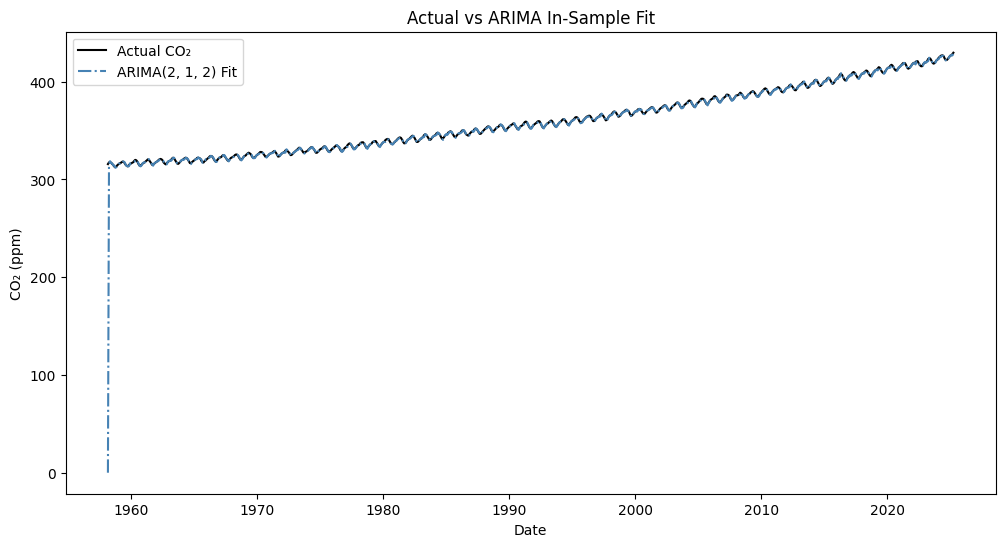

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['co2'],      color='black',     label='Actual CO₂')
plt.plot(df.index, arima_fitted,    color='steelblue', linestyle='-.', label=f'ARIMA{arima_order} Fit')
plt.title("Actual vs ARIMA In-Sample Fit")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.show()

In [39]:
mask = ~np.isnan(arima_fitted)
actual = df['co2'][mask]
predicted = arima_fitted[mask]

# Calculate MAE and RMSE
mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted) ** 0.5

print(f"ARIMA{arima_order} In-Sample MAE: {mae:.3f}, RMSE: {rmse:.3f}")

ARIMA(2, 1, 2) In-Sample MAE: 0.942, RMSE: 11.143


### sarima

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_order = (2, 1, 2)
seasonal_order = (1, 1, 1, 12)  


sarima_model = SARIMAX(
    df['co2'],
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
sarima_fitted = sarima_model.fittedvalues


In [56]:



burn_in = 13 

actual = df['co2'][burn_in:]
fitted = sarima_fitted[burn_in:]

mae = mean_absolute_error(actual, fitted)
rmse = np.sqrt(mean_squared_error(actual, fitted))

print(f"SARIMA In-Sample MAE: {mae:.3f}")
print(f"SARIMA In-Sample RMSE: {rmse:.3f}")


SARIMA In-Sample MAE: 0.338
SARIMA In-Sample RMSE: 1.959


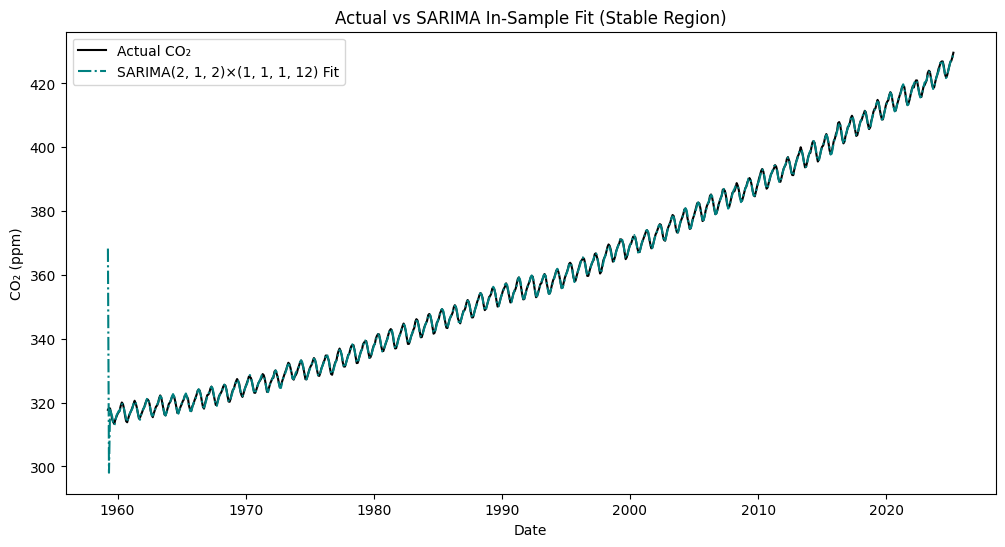

In [54]:
# Remove the initial unstable predictions (burn-in)
burn_in = 13  # Can adjust to max(p, d, q, P*seasonal, D*seasonal, Q*seasonal)
plt.figure(figsize=(12,6))
plt.plot(df.index[burn_in:], df['co2'][burn_in:], color='black', label='Actual CO₂')
plt.plot(df.index[burn_in:], sarima_fitted[burn_in:], color='teal', linestyle='-.', label=f'SARIMA{sarima_order}×{seasonal_order} Fit')
plt.title("Actual vs SARIMA In-Sample Fit (Stable Region)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.show()


### Holt Winter

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(
    df['co2'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
hw_fitted = hw_model.fittedvalues

/Users/mdmahfuzurrahman/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


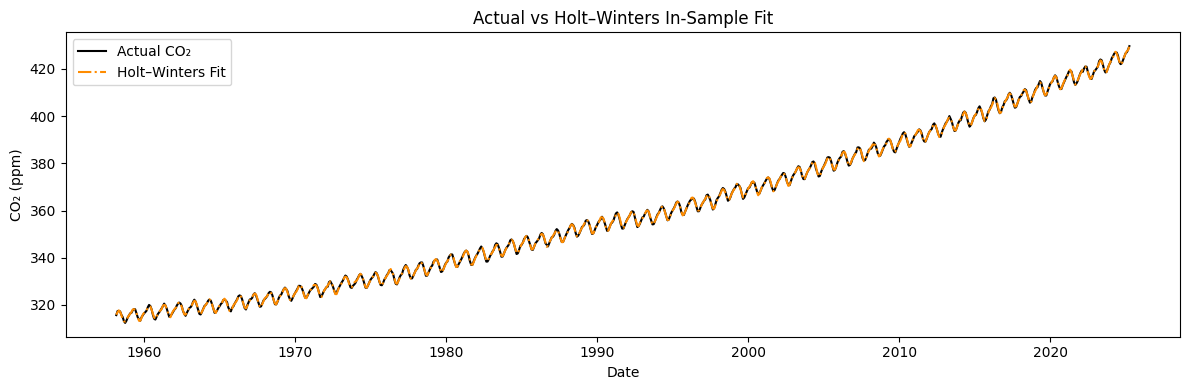

In [22]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['co2'],   color='black',      label='Actual CO₂')
plt.plot(df.index, hw_fitted,    color='darkorange', linestyle='-.', label='Holt–Winters Fit')
plt.title("Actual vs Holt–Winters In-Sample Fit")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

hw_mae  = mean_absolute_error(df['co2'], hw_fitted)
hw_rmse = np.sqrt(mean_squared_error(df['co2'], hw_fitted))
print(f"Holt–Winters   MAE: {hw_mae:.3f}, RMSE: {hw_rmse:.3f}")

Holt–Winters   MAE: 0.249, RMSE: 0.318


### Ml model

In [25]:
N_LAGS = 12
df_ml = pd.DataFrame({'y': df['co2']})
for lag in range(1, N_LAGS+1):
    df_ml[f'lag_{lag}'] = df_ml['y'].shift(lag)
df_ml['time_idx'] = np.arange(len(df_ml))
df_ml['month']    = df_ml.index.month
df_ml.dropna(inplace=True)

# 2. Train/Test split (last 5 years → 60 months as TEST)
TEST_MONTHS = 60
train_ml = df_ml.iloc[:-TEST_MONTHS]
test_ml  = df_ml.iloc[-TEST_MONTHS:]

X_train = train_ml.drop('y', axis=1).values
y_train = train_ml['y'].values
X_test  = test_ml.drop('y', axis=1).values
y_test  = test_ml['y'].values
test_idx = test_ml.index

### Random Forest

In [26]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_train_rf = rf.predict(X_train)
y_test_rf  = rf.predict(X_test)

rf_train_mae  = mean_absolute_error(y_train, y_train_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_rf))
rf_test_mae   = mean_absolute_error(y_test,  y_test_rf)
rf_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_rf))

print(f"Random Forest  TRAIN MAE: {rf_train_mae:.3f}, RMSE: {rf_train_rmse:.3f}")
print(f"Random Forest  TEST  MAE: {rf_test_mae:.3f}, RMSE: {rf_test_rmse:.3f}")


Random Forest  TRAIN MAE: 0.175, RMSE: 0.222
Random Forest  TEST  MAE: 4.669, RMSE: 5.960


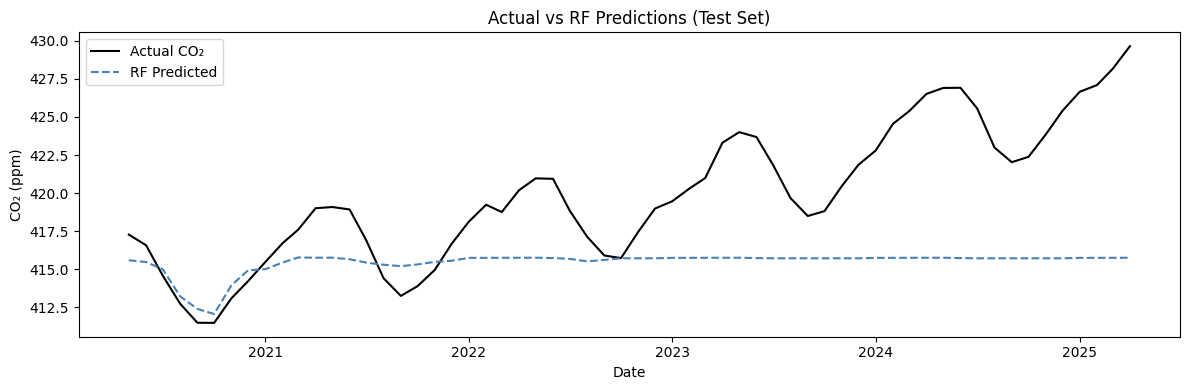

In [27]:
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_test,        color='black',     label='Actual CO₂')
plt.plot(test_idx, y_test_rf,     color='steelblue', linestyle='--', label='RF Predicted')
plt.title("Actual vs RF Predictions (Test Set)")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout() 
plt.show()

### LSTM

In [28]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1))


X_train_lstm = X_train_scaled.reshape(-1, N_LAGS+2, 1)  
X_test_lstm  = X_test_scaled.reshape(-1,  N_LAGS+2, 1)

model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_scaled, epochs=30, batch_size=16, verbose=0)

y_train_lstm = scaler_y.inverse_transform(model.predict(X_train_lstm)).flatten()
y_test_lstm  = scaler_y.inverse_transform(model.predict(X_test_lstm)).flatten()

lstm_train_mae  = mean_absolute_error(y_train, y_train_lstm)
lstm_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_lstm))
lstm_test_mae   = mean_absolute_error(y_test,  y_test_lstm)
lstm_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_lstm))


/Users/mdmahfuzurrahman/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [31]:
print(f"LSTM          TRAIN MAE: {lstm_train_mae:.3f}, RMSE: {lstm_train_rmse:.3f}")
print(f"LSTM          TEST  MAE: {lstm_test_mae:.3f}, RMSE: {lstm_test_rmse:.3f}")

LSTM          TRAIN MAE: 1.412, RMSE: 1.640
LSTM          TEST  MAE: 1.533, RMSE: 1.833


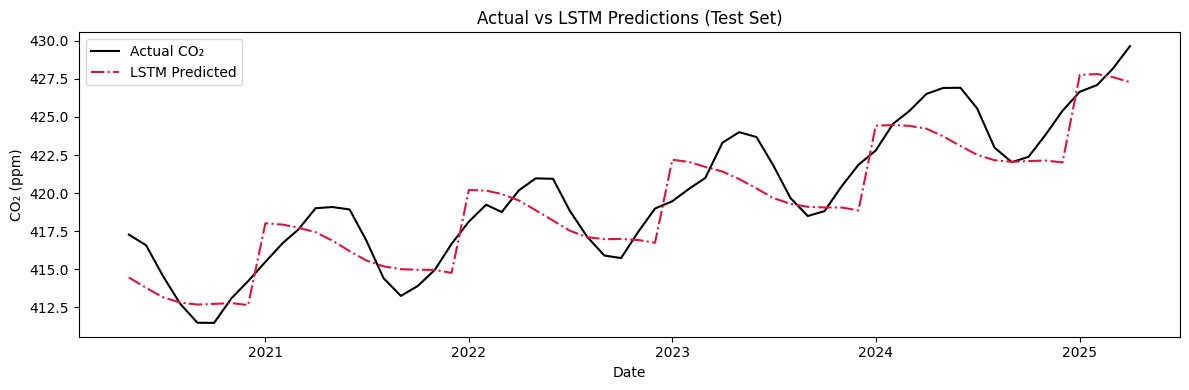

In [32]:
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_test,        color='black',     label='Actual CO₂')
plt.plot(test_idx, y_test_lstm,   color='crimson',   linestyle='-.', label='LSTM Predicted')
plt.title("Actual vs LSTM Predictions (Test Set)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
ann = MLPRegressor(
    hidden_layer_sizes=(64,32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
ann.fit(X_train, y_train)

y_train_ann = ann.predict(X_train)
y_test_ann  = ann.predict(X_test)

ann_train_mae  = mean_absolute_error(y_train, y_train_ann)
ann_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_ann))
ann_test_mae   = mean_absolute_error(y_test,  y_test_ann)
ann_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_ann))

In [35]:
print(f"ANN           TRAIN MAE: {ann_train_mae:.3f}, RMSE: {ann_train_rmse:.3f}")
print(f"ANN           TEST  MAE: {ann_test_mae:.3f}, RMSE: {ann_test_rmse:.3f}")

ANN           TRAIN MAE: 1.292, RMSE: 1.587
ANN           TEST  MAE: 1.337, RMSE: 1.644


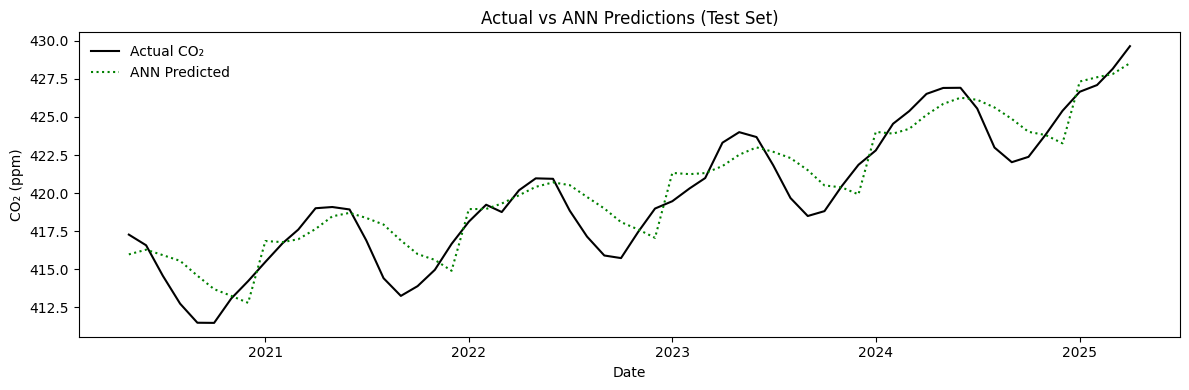

In [37]:
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_test,        'k-',  label='Actual CO₂')
plt.plot(test_idx, y_test_ann,    'g:',  label='ANN Predicted')
plt.title("Actual vs ANN Predictions (Test Set)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### all ml models 

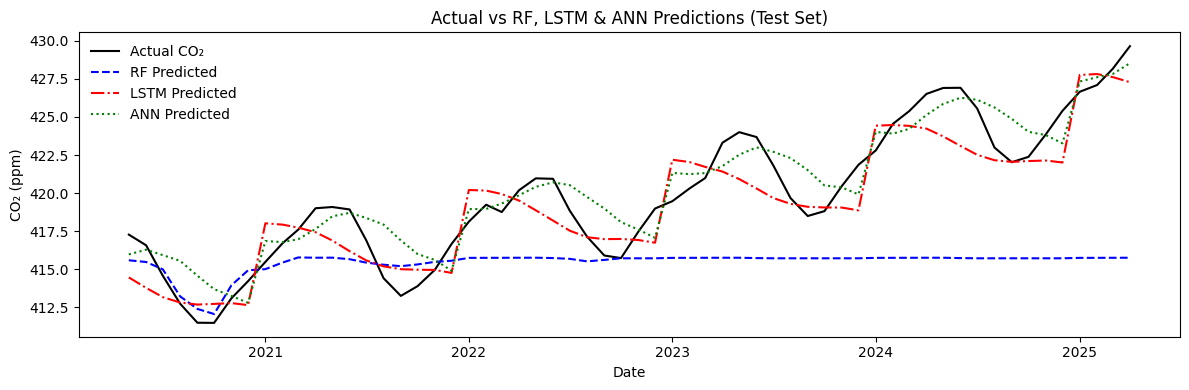

In [38]:
plt.figure(figsize=(12,4))
plt.plot(test_idx, y_test,        'k-',  label='Actual CO₂')
plt.plot(test_idx, y_test_rf,     'b--', label='RF Predicted')
plt.plot(test_idx, y_test_lstm,   'r-.', label='LSTM Predicted')
plt.plot(test_idx, y_test_ann,    'g:',  label='ANN Predicted')

plt.title("Actual vs RF, LSTM & ANN Predictions (Test Set)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Forecast 

In [40]:
n_forecast = 60

last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=n_forecast, freq='MS')
forecast = arima_model.forecast(steps=n_forecast)

df_forecast = pd.DataFrame({'co2': forecast}, index=future_dates)


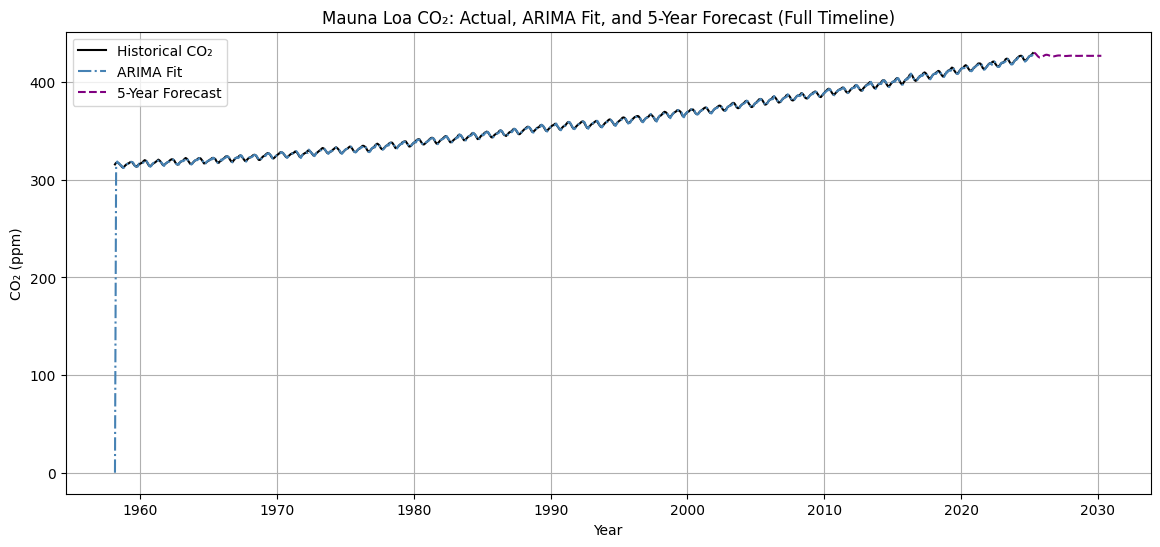

In [41]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['co2'], label='Historical CO₂', color='black')
plt.plot(df.index, arima_fitted, label='ARIMA Fit', color='steelblue', linestyle='-.')
plt.plot(df_forecast.index, df_forecast['co2'], label='5-Year Forecast', color='purple', linestyle='--')
plt.title("Mauna Loa CO₂: Actual, ARIMA Fit, and 5-Year Forecast (Full Timeline)")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.show()


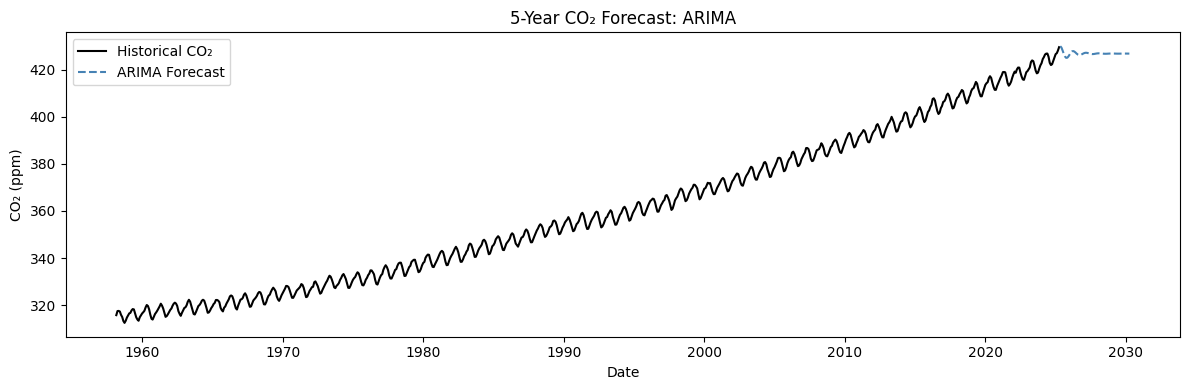

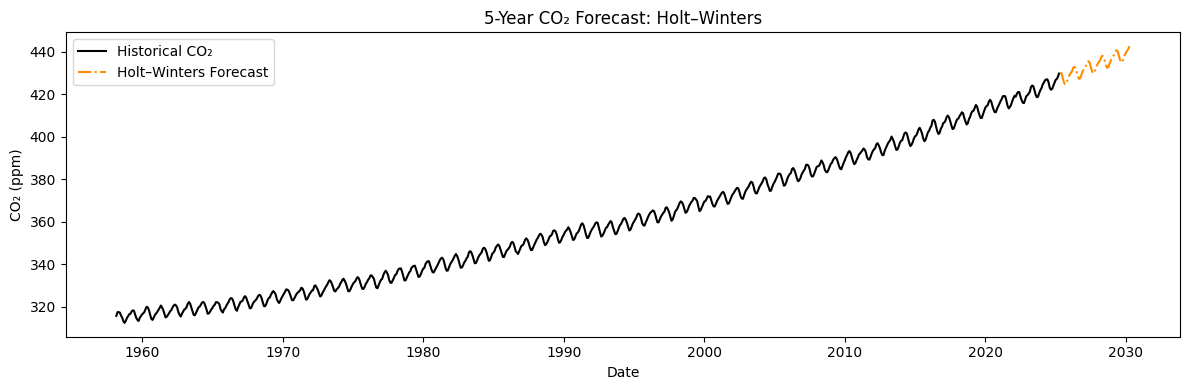

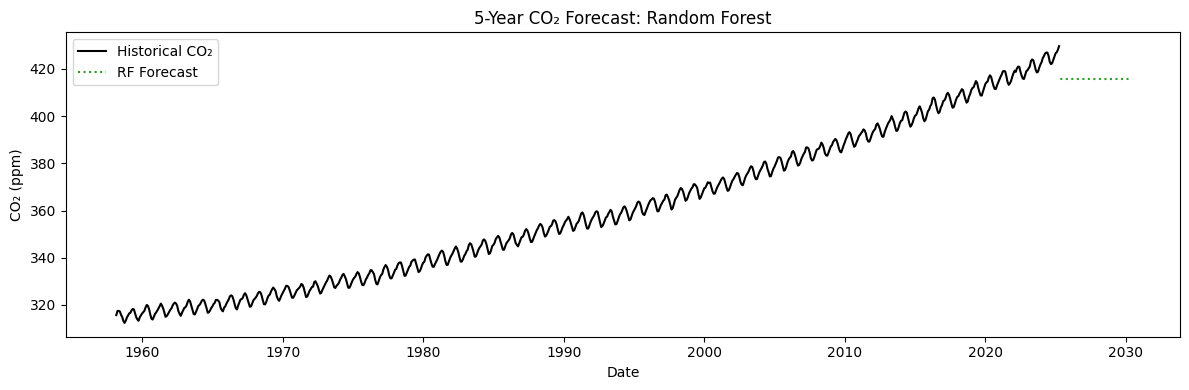

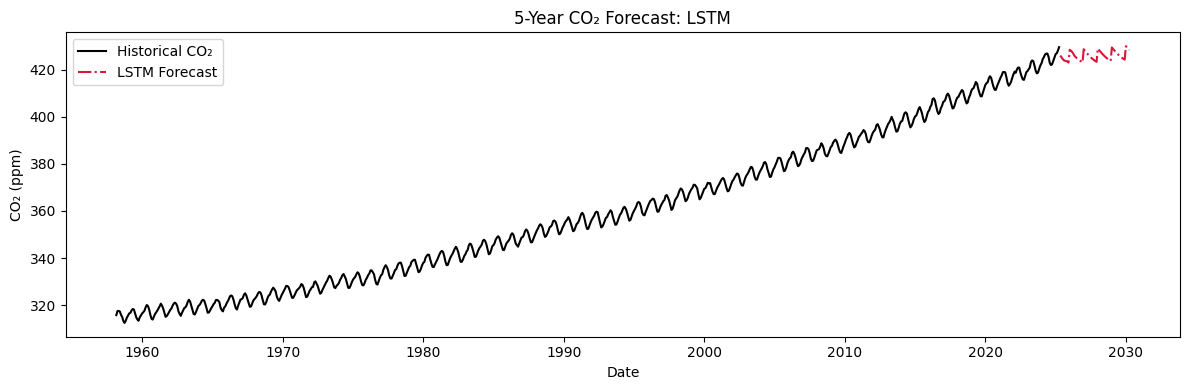

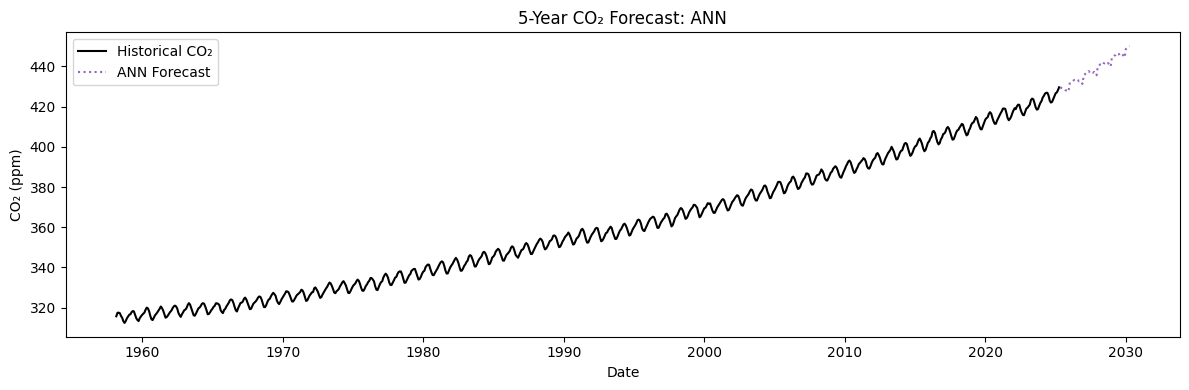

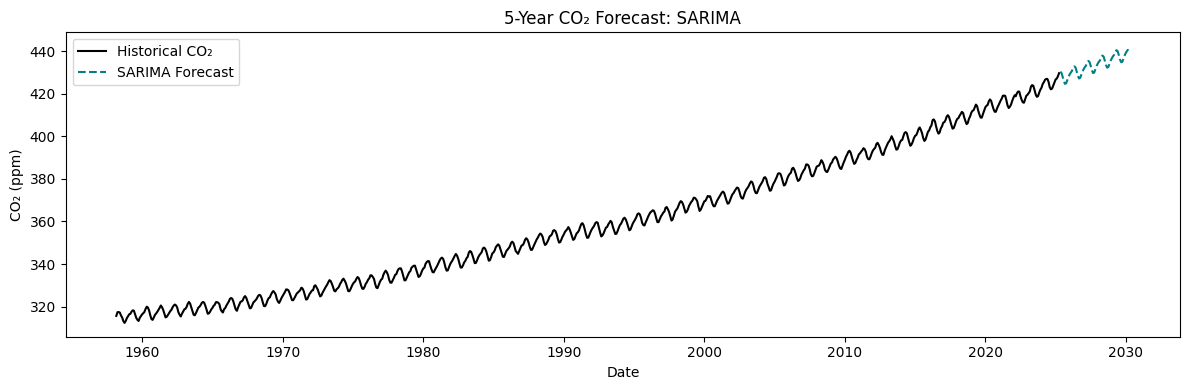

In [58]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthBegin

# 1. Prepare future dates (next 60 months)
last_date   = df.index[-1]
future_dates = pd.date_range(last_date + MonthBegin(1), periods=60, freq='MS')

# --- ARIMA Forecast ---
arima_forecast = arima_model.forecast(steps=60)
arima_forecast.index = future_dates

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(arima_forecast, color='steelblue', linestyle='--', label='ARIMA Forecast')
plt.title("5-Year CO₂ Forecast: ARIMA")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()

# --- Holt–Winters Forecast ---
hw_forecast = hw_model.forecast(60)
hw_forecast.index = future_dates

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(hw_forecast, color='darkorange', linestyle='-.', label='Holt–Winters Forecast')
plt.title("5-Year CO₂ Forecast: Holt–Winters")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()

# --- Random Forest Forecast ---
# Feature names
feature_names = train_ml.drop('y', axis=1).columns.tolist()

lags     = list(df['co2'][-N_LAGS:])
time_idx = train_ml['time_idx'].iloc[-1] + 1
rf_preds = []

for i in range(60):
    date_i = last_date + MonthBegin(i+1)
    month  = date_i.month
    feat   = {f'lag_{lag}': lags[-lag] for lag in range(1, N_LAGS+1)}
    feat['time_idx'], feat['month'] = time_idx + i, month

    X_new = pd.DataFrame([ [feat[name] for name in feature_names] ],
                         columns=feature_names)
    p = rf.predict(X_new)[0]
    rf_preds.append(p)
    lags.append(p)

rf_forecast = pd.Series(rf_preds, index=future_dates)

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(rf_forecast, color='tab:green', linestyle=':', label='RF Forecast')
plt.title("5-Year CO₂ Forecast: Random Forest")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()

# --- LSTM Forecast ---
lags     = list(df['co2'][-N_LAGS:])
time_idx = train_ml['time_idx'].iloc[-1] + 1
lstm_preds = []

for i in range(60):
    date_i = last_date + MonthBegin(i+1)
    month  = date_i.month
    vals   = [lags[-lag] for lag in range(1, N_LAGS+1)] + [time_idx + i, month]
    Xs     = scaler_X.transform([vals]).reshape(1, len(vals), 1)
    ys     = model.predict(Xs, verbose=0)[0,0]
    p      = scaler_y.inverse_transform([[ys]])[0,0]
    lstm_preds.append(p)
    lags.append(p)

lstm_forecast = pd.Series(lstm_preds, index=future_dates)

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(lstm_forecast, color='crimson', linestyle='-.', label='LSTM Forecast')
plt.title("5-Year CO₂ Forecast: LSTM")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()

# --- ANN Forecast ---
lags     = list(df['co2'][-N_LAGS:])
time_idx = train_ml['time_idx'].iloc[-1] + 1
ann_preds = []

for i in range(60):
    date_i = last_date + MonthBegin(i+1)
    month  = date_i.month
    vals   = [lags[-lag] for lag in range(1, N_LAGS+1)] + [time_idx + i, month]
    p      = ann.predict([vals])[0]
    ann_preds.append(p)
    lags.append(p)

ann_forecast = pd.Series(ann_preds, index=future_dates)

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(ann_forecast, color='tab:purple', linestyle=':', label='ANN Forecast')
plt.title("5-Year CO₂ Forecast: ANN")
plt.xlabel("Date"); plt.ylabel("CO₂ (ppm)")
plt.legend(); plt.tight_layout(); plt.show()
import warnings
warnings.filterwarnings("ignore")


sarima_order = (2, 1, 2)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(
    df['co2'],
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# --- SARIMA Forecast ---
sarima_forecast = sarima_model.get_forecast(steps=60)
sarima_mean = sarima_forecast.predicted_mean
sarima_mean.index = future_dates

plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(sarima_mean, color='teal', linestyle='--', label='SARIMA Forecast')
plt.title("5-Year CO₂ Forecast: SARIMA")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()


### best 

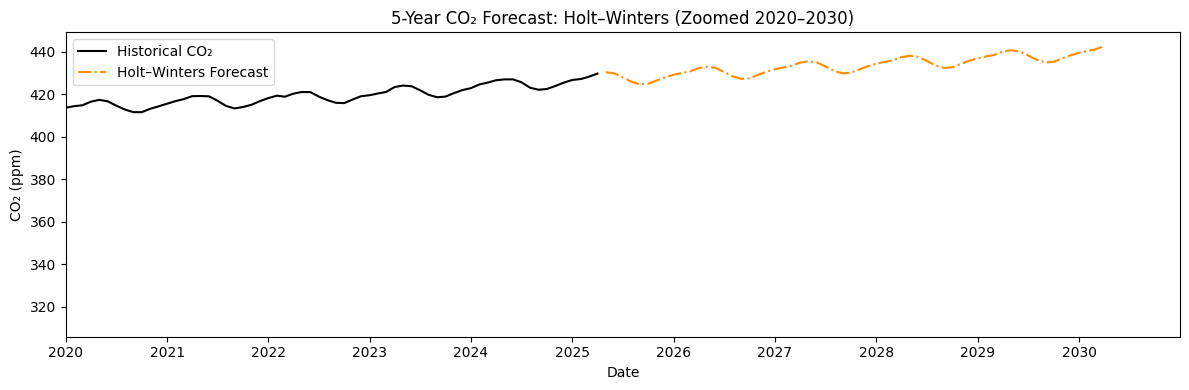

In [46]:
plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(hw_forecast, color='darkorange', linestyle='-.', label='Holt–Winters Forecast')
plt.title("5-Year CO₂ Forecast: Holt–Winters (Zoomed 2020–2030)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2030-12-31'))
plt.legend()
plt.tight_layout()
plt.show()


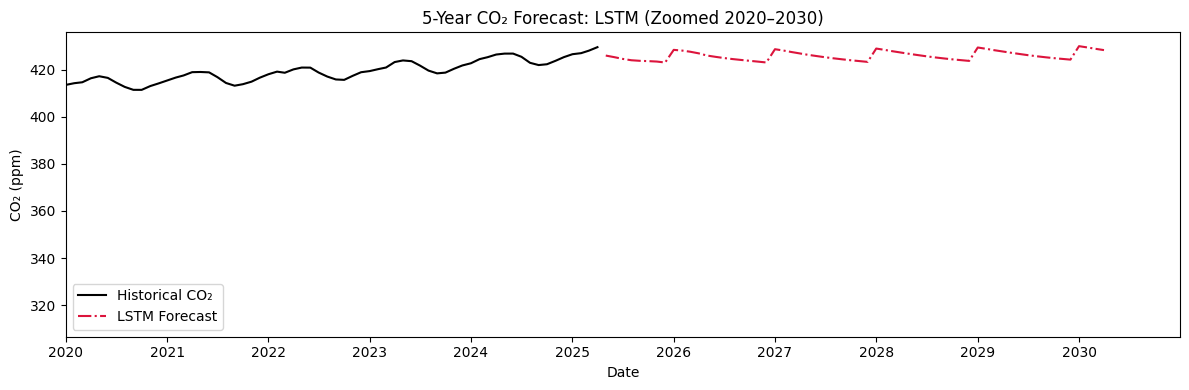

In [61]:
plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(lstm_forecast, color='crimson', linestyle='-.', label='LSTM Forecast')
plt.title("5-Year CO₂ Forecast: LSTM (Zoomed 2020–2030)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2030-12-31'))
plt.legend()
plt.tight_layout()
plt.show()


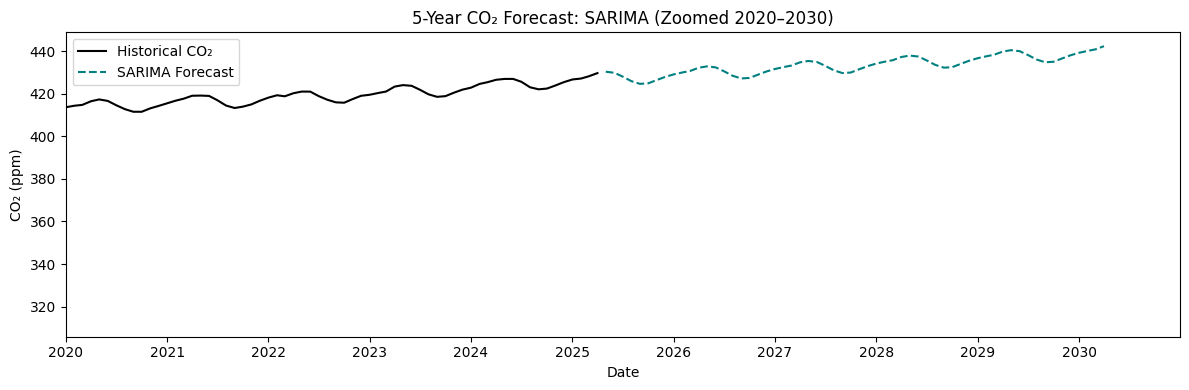

In [63]:
plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(sarima_mean, color='teal', linestyle='--', label='SARIMA Forecast')
plt.title("5-Year CO₂ Forecast: SARIMA (Zoomed 2020–2030)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2030-12-31'))
plt.legend()
plt.tight_layout()
plt.show()


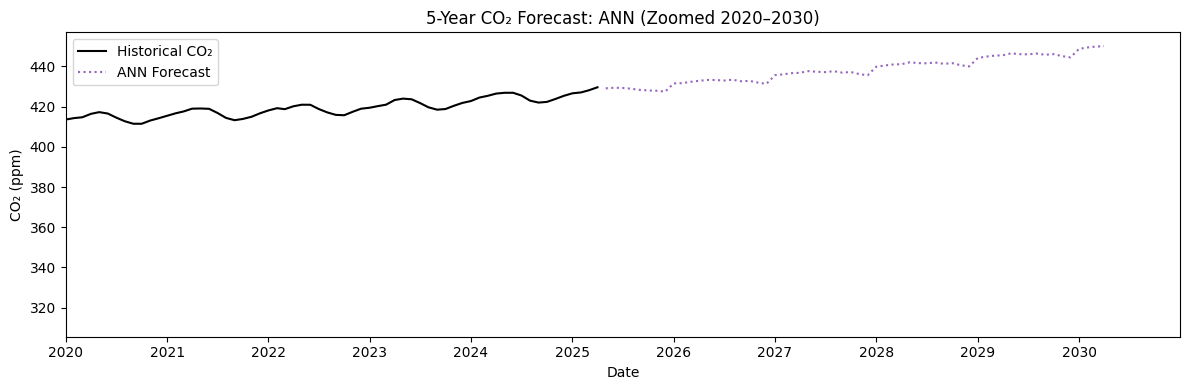

In [64]:
plt.figure(figsize=(12,4))
plt.plot(df['co2'], color='black', label='Historical CO₂')
plt.plot(ann_forecast, color='tab:purple', linestyle=':', label='ANN Forecast')
plt.title("5-Year CO₂ Forecast: ANN (Zoomed 2020–2030)")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2030-12-31'))
plt.legend()
plt.tight_layout()
plt.show()


| Model          | Set   | MAE   | RMSE   |
|----------------|-------|-------|--------|
| ARIMA(2,1,2)   | Train | 0.942 | 11.143 |
| SARIMA         | Train | 0.338 |  1.959 |
| Holt–Winters   | Train | 0.249 |  0.318 |
| Random Forest  | Train | 0.175 |  0.222 |
| Random Forest  | Test  | 4.669 |  5.960 |
| LSTM           | Train | 1.412 |  1.640 |
| LSTM           | Test  | 1.533 |  1.833 |
| ANN            | Train | 1.292 |  1.587 |
| ANN            | Test  | 1.337 |  1.644 |

pass


## Regime Shift 

In [69]:
import ruptures as rpt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

stl       = STL(df['co2'], period=12, robust=True)
res       = stl.fit()
residuals = res.resid.dropna()  
df['residual'] = df['co2'] - res.trend
detrended = df['residual'].values
 
algo = rpt.Pelt(model="l2").fit(detrended)
penalty = 3  
bkpts = algo.predict(pen=penalty)
dates_pelt = [df.index[b-1] for b in bkpts]  

print("PELT change-points at:", dates_pelt)

PELT change-points at: [Timestamp('1958-07-01 00:00:00'), Timestamp('1958-12-01 00:00:00'), Timestamp('1959-05-01 00:00:00'), Timestamp('1960-03-01 00:00:00'), Timestamp('1960-08-01 00:00:00'), Timestamp('1961-01-01 00:00:00'), Timestamp('1961-06-01 00:00:00'), Timestamp('1961-11-01 00:00:00'), Timestamp('1962-09-01 00:00:00'), Timestamp('1963-02-01 00:00:00'), Timestamp('1963-07-01 00:00:00'), Timestamp('1963-12-01 00:00:00'), Timestamp('1964-05-01 00:00:00'), Timestamp('1965-03-01 00:00:00'), Timestamp('1965-08-01 00:00:00'), Timestamp('1966-01-01 00:00:00'), Timestamp('1966-06-01 00:00:00'), Timestamp('1966-11-01 00:00:00'), Timestamp('1967-09-01 00:00:00'), Timestamp('1968-02-01 00:00:00'), Timestamp('1968-07-01 00:00:00'), Timestamp('1968-12-01 00:00:00'), Timestamp('1969-05-01 00:00:00'), Timestamp('1970-03-01 00:00:00'), Timestamp('1970-08-01 00:00:00'), Timestamp('1971-01-01 00:00:00'), Timestamp('1971-06-01 00:00:00'), Timestamp('1971-11-01 00:00:00'), Timestamp('1972-09-01 00

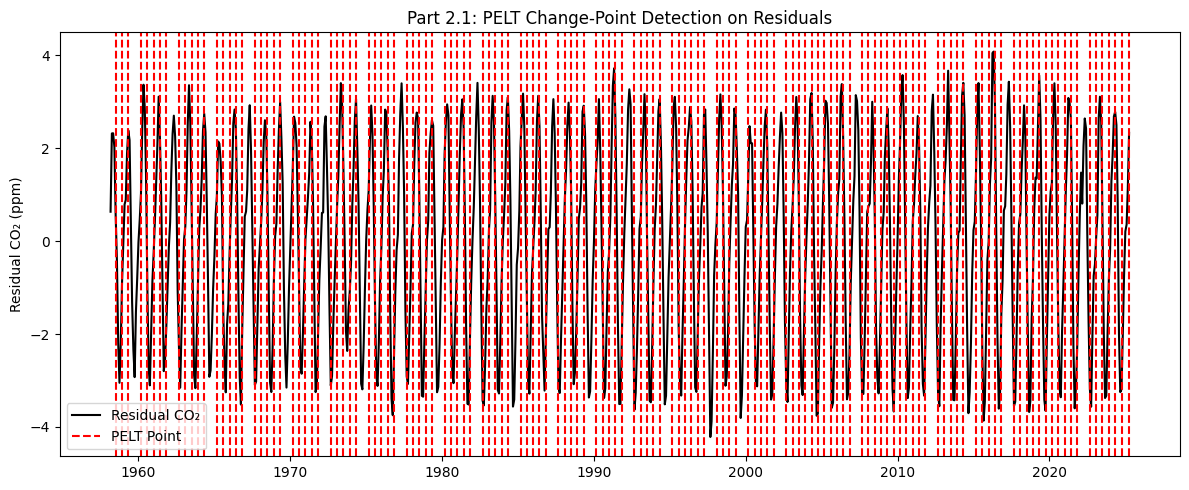

In [70]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['residual'], color='black', label='Residual CO₂')
for dt in dates_pelt:
    plt.axvline(dt, color='red', linestyle='--', label='PELT Point' if dt==dates_pelt[0] else "")
plt.title("Part 2.1: PELT Change-Point Detection on Residuals")
plt.ylabel("Residual CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()

PELT points: 161,  Up-shifts: 94,  Down-shifts: 114


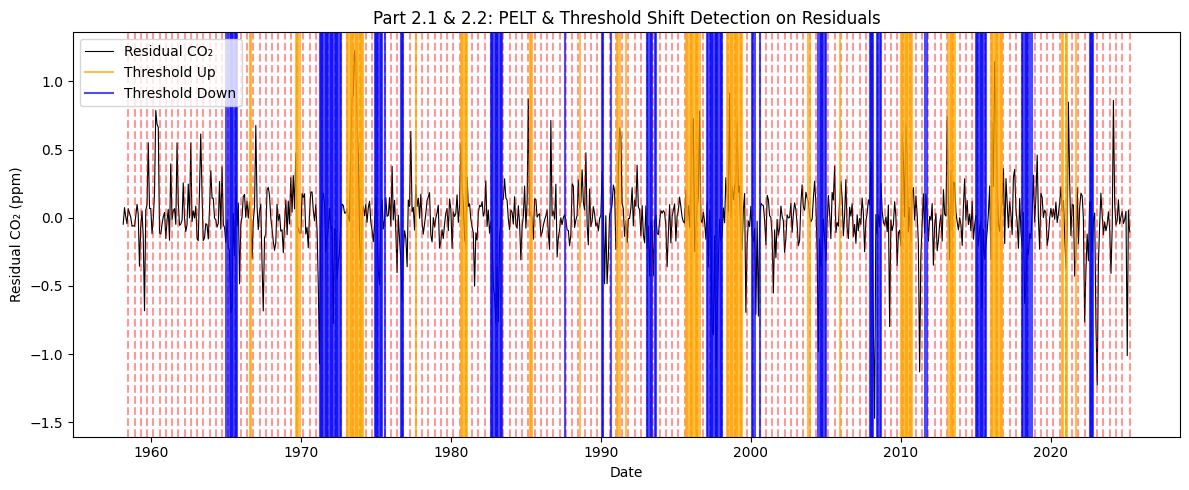

In [71]:

stl       = STL(df['co2'], period=12, robust=True)
res       = stl.fit()
residuals = res.resid.dropna()

algo      = rpt.Pelt(model="rbf").fit(residuals.values)
penalty   = 1e-3
bkpts     = algo.predict(pen=penalty)
dates_pelt = [residuals.index[b-1] for b in bkpts if b-1 >= 0]


short_ma  = residuals.rolling(window=12, center=True).mean()
long_ma   = residuals.rolling(window=60, center=True).mean()
diff      = short_ma - long_ma
thr       = diff.std() * 1.0    


dates_up   = diff[diff >  thr].index
dates_down = diff[diff < -thr].index

print(f"PELT points: {len(dates_pelt)},  Up-shifts: {len(dates_up)},  Down-shifts: {len(dates_down)}")


plt.figure(figsize=(12,5))
plt.plot(residuals.index, residuals.values, color='black', linewidth=0.8, label='Residual CO₂')

for dt in dates_pelt:
    plt.axvline(dt, color='red', linestyle='--', alpha=0.4)

for i, dt in enumerate(dates_up):
    plt.axvline(dt, color='orange', linestyle='-', alpha=0.7,
                label='Threshold Up' if i == 0 else "")

for i, dt in enumerate(dates_down):
    plt.axvline(dt, color='blue', linestyle='-', alpha=0.7,
                label='Threshold Down' if i == 0 else "")

plt.title("Part 2.1 & 2.2: PELT & Threshold Shift Detection on Residuals")
plt.xlabel("Date")
plt.ylabel("Residual CO₂ (ppm)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


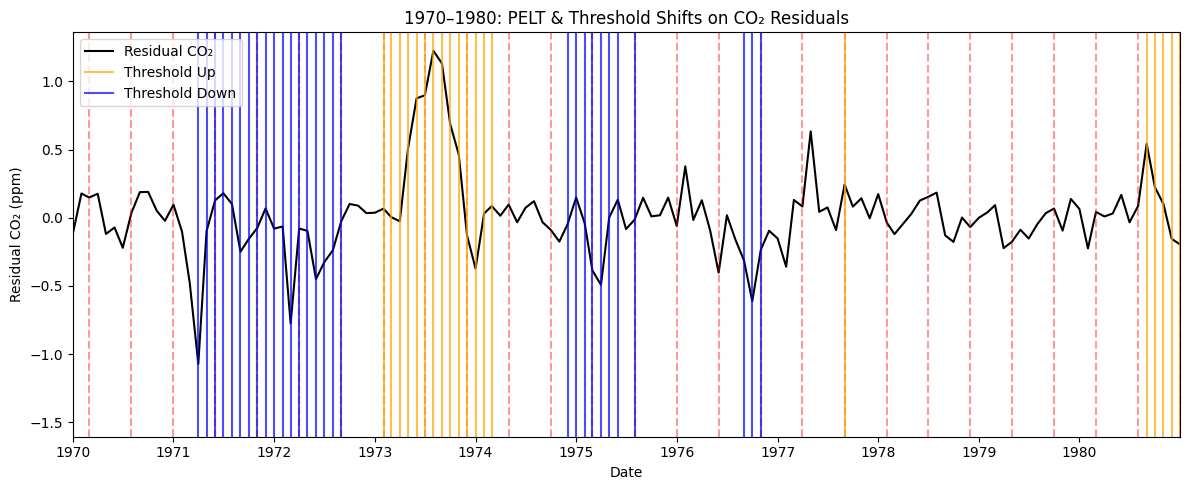

In [72]:


# 4. Plot zoomed 1970–1980
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(residuals.index, residuals.values, 'k-', label='Residual CO₂')
for dt in dates_pelt:
    ax.axvline(dt, color='red', linestyle='--', alpha=0.4)
for i, dt in enumerate(dates_up):
    ax.axvline(dt, color='orange', linestyle='-', alpha=0.7,
               label='Threshold Up' if i==0 else "")
for i, dt in enumerate(dates_down):
    ax.axvline(dt, color='blue', linestyle='-', alpha=0.7,
               label='Threshold Down' if i==0 else "")

# **HERE**: zoom x-axis
ax.set_xlim(pd.Timestamp('1970-01-01'), pd.Timestamp('1980-12-31'))

ax.set_title("1970–1980: PELT & Threshold Shifts on CO₂ Residuals")
ax.set_xlabel("Date")
ax.set_ylabel("Residual CO₂ (ppm)")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


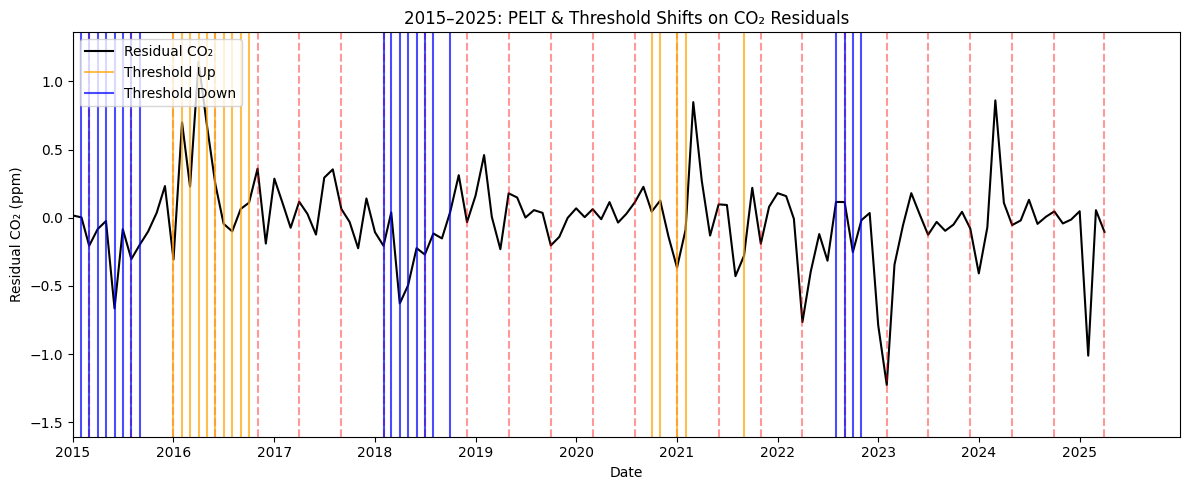

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(residuals.index, residuals.values, 'k-', label='Residual CO₂')

for dt in dates_pelt:
    ax.axvline(dt, color='red', linestyle='--', alpha=0.4)
for i, dt in enumerate(dates_up):
    ax.axvline(dt, color='orange', linestyle='-', alpha=0.7,
               label='Threshold Up' if i==0 else "")
for i, dt in enumerate(dates_down):
    ax.axvline(dt, color='blue', linestyle='-', alpha=0.7,
               label='Threshold Down' if i==0 else "")

# Zoom into 2015–2025
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2025-12-31'))

ax.set_title("2015–2025: PELT & Threshold Shifts on CO₂ Residuals")
ax.set_xlabel("Date")
ax.set_ylabel("Residual CO₂ (ppm)")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

                      Event      Start        End
Late 1970s CO₂ Acceleration 1972-01-01 1976-12-31
               COVID-19 Dip 2020-02-01 2021-12-31


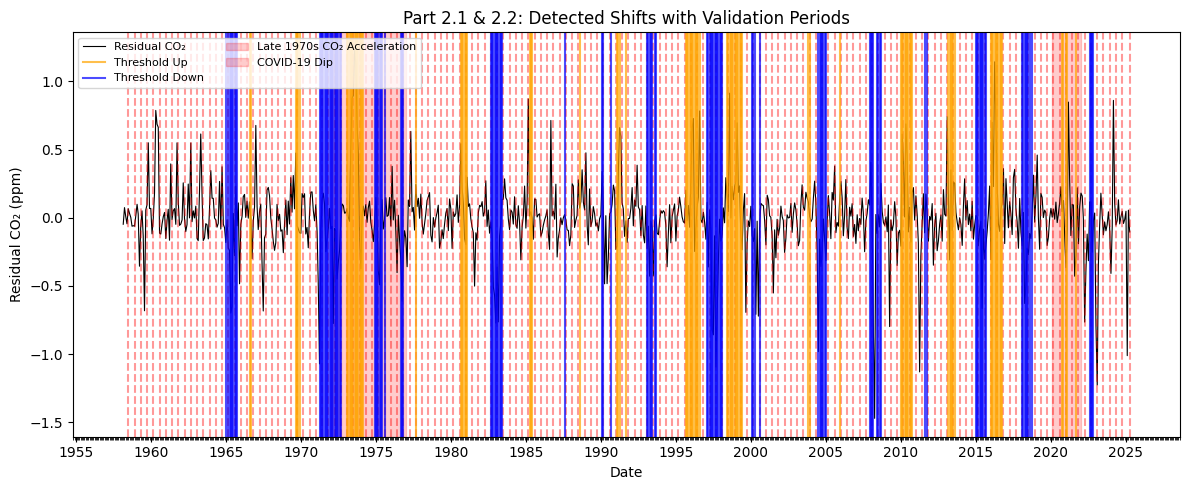

In [75]:
import matplotlib.dates as mdates
events = [
    ("Late 1970s CO₂ Acceleration", "1972-01-01", "1976-12-31"),
    ("COVID-19 Dip",             "2020-02-01", "2021-12-31"),
]
val_df = pd.DataFrame(events, columns=["Event", "Start", "End"])
val_df["Start"] = pd.to_datetime(val_df["Start"])
val_df["End"]   = pd.to_datetime(val_df["End"])

print(val_df.to_string(index=False))


fig, ax = plt.subplots(figsize=(12,5))

ax.plot(residuals.index, residuals.values,
        color='black', linewidth=0.8, label='Residual CO₂')

for dt in dates_pelt:
    ax.axvline(dt, color='red', linestyle='--', alpha=0.4)

for i, dt in enumerate(dates_up):
    ax.axvline(dt, color='orange', linestyle='-', alpha=0.7,
               label='Threshold Up' if i==0 else "")
for i, dt in enumerate(dates_down):
    ax.axvline(dt, color='blue', linestyle='-', alpha=0.7,
               label='Threshold Down' if i==0 else "")

for label, start, end in zip(val_df["Event"], val_df["Start"], val_df["End"]):
    ax.axvspan(start, end, color='red', alpha=0.2, label=label)

ax.set_title("Part 2.1 & 2.2: Detected Shifts with Validation Periods")
ax.set_xlabel("Date")
ax.set_ylabel("Residual CO₂ (ppm)")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.legend(loc='upper left', ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


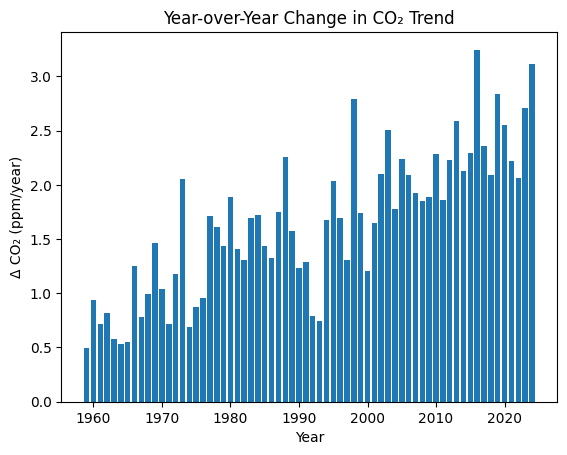

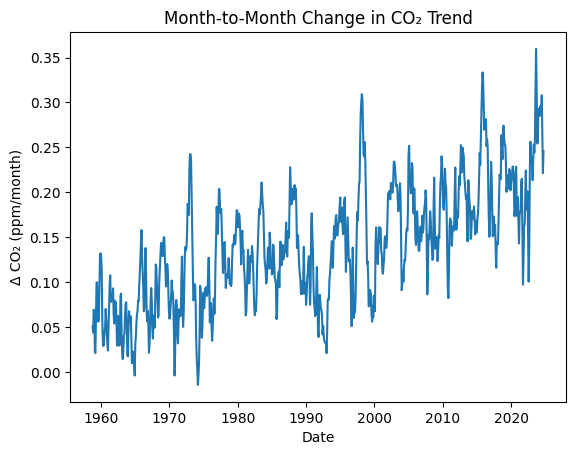

In [90]:

trend_annual = trend.resample('A').mean()
trend_annual_delta = trend_annual.diff()


trend_monthly_delta = trend.diff()


plt.bar(trend_annual_delta.index.year, trend_annual_delta.values)
plt.title("Year-over-Year Change in CO₂ Trend")
plt.xlabel("Year")
plt.ylabel("Δ CO₂ (ppm/year)")
plt.show()



plt.plot(trend_monthly_delta.index, trend_monthly_delta.values)
plt.title("Month-to-Month Change in CO₂ Trend")
plt.xlabel("Date")
plt.ylabel("Δ CO₂ (ppm/month)")
plt.show()


In [88]:
# Show top 5 rises and declines in annual trend change
print("Top 5 annual CO₂ rises:")
print(trend_annual_delta.sort_values(ascending=False).head())

print("\nTop 5 annual CO₂ declines:")
print(trend_annual_delta.sort_values().head())


Top 5 annual CO₂ rises:
date
2016-12-31    3.245278
2024-12-31    3.113799
2019-12-31    2.836424
1998-12-31    2.793194
2023-12-31    2.709896
Name: trend, dtype: float64

Top 5 annual CO₂ declines:
date
1959-12-31    0.496701
1964-12-31    0.529063
1965-12-31    0.549028
1963-12-31    0.576146
1974-12-31    0.687465
Name: trend, dtype: float64


In [ ]:
import ruptures as rpt


trend_no_nan = trend.dropna()

algo = rpt.Pelt(model='rbf').fit(trend_no_nan.values)
breakpoints = algo.predict(pen=10)  

trend_index = trend_no_nan.index
break_dates = [trend_index[b-1] for b in breakpoints if b-1 < len(trend_index)]

trend_annual = trend_no_nan.resample('A').mean()
trend_annual_delta = trend_annual.diff()
break_years = [d.year for d in break_dates if d.year in trend_annual_delta.index.year]
break_deltas = [trend_annual_delta[trend_annual_delta.index.year == y].values[0] if y in trend_annual_delta.index.year else None for y in break_years]

for date, delta in zip(break_dates, break_deltas):
    print(f"Regime shift at {date.date()}: Δ CO₂ ≈ {delta:.2f} ppm/year")


Regime shift at 1973-03-01: Δ CO₂ ≈ 2.05 ppm/year
Regime shift at 1985-04-01: Δ CO₂ ≈ 1.43 ppm/year
Regime shift at 1997-10-01: Δ CO₂ ≈ 1.31 ppm/year
Regime shift at 2006-12-01: Δ CO₂ ≈ 2.09 ppm/year
Regime shift at 2016-02-01: Δ CO₂ ≈ 3.25 ppm/year
Regime shift at 2024-10-01: Δ CO₂ ≈ 3.11 ppm/year


In [ ]:
threshold = 1.5

big_rises = trend_annual_delta[trend_annual_delta > threshold]
big_declines = trend_annual_delta[trend_annual_delta < -threshold]

print("\nBig Rises (Δ CO₂ > +1.5 ppm/year):")
print(big_rises)

print("\nBig Declines (Δ CO₂ < -1.5 ppm/year):")
print(big_declines)



Big Rises (Δ CO₂ > +1.5 ppm/year):
date
1973-12-31    2.050417
1977-12-31    1.714653
1978-12-31    1.612951
1980-12-31    1.886563
1983-12-31    1.695764
1984-12-31    1.724618
1987-12-31    1.749861
1988-12-31    2.257326
1989-12-31    1.573785
1994-12-31    1.676319
1995-12-31    2.034132
1996-12-31    1.691007
1998-12-31    2.793194
1999-12-31    1.744167
2001-12-31    1.644271
2002-12-31    2.098333
2003-12-31    2.504688
2004-12-31    1.781319
2005-12-31    2.233993
2006-12-31    2.093264
2007-12-31    1.920556
2008-12-31    1.848576
2009-12-31    1.883611
2010-12-31    2.285174
2011-12-31    1.861493
2012-12-31    2.231076
2013-12-31    2.586979
2014-12-31    2.126806
2015-12-31    2.288854
2016-12-31    3.245278
2017-12-31    2.357604
2018-12-31    2.090521
2019-12-31    2.836424
2020-12-31    2.548819
2021-12-31    2.218299
2022-12-31    2.067188
2023-12-31    2.709896
2024-12-31    3.113799
Name: trend, dtype: float64

Big Declines (Δ CO₂ < -1.5 ppm/year):
Series([], Freq: Y

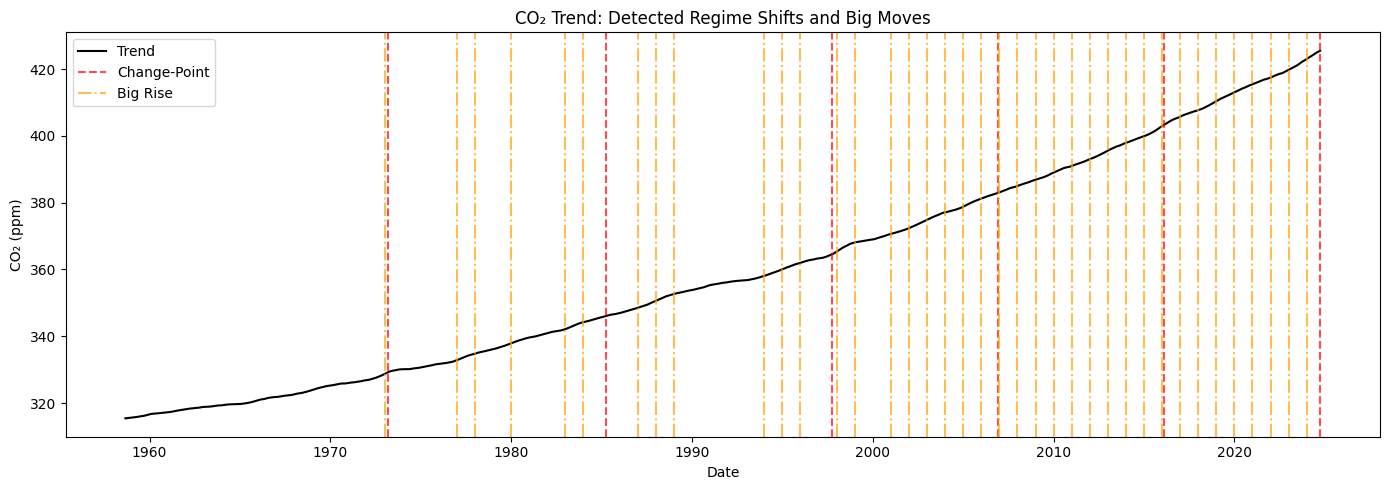

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(trend_no_nan.index, trend_no_nan.values, label='Trend', color='black')

for i, date in enumerate(break_dates):
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.7, label='Change-Point' if i==0 else "")

for year in big_rises.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='orange', linestyle='-.', alpha=0.7, label='Big Rise' if year == big_rises.index.year[0] else "")
for year in big_declines.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='blue', linestyle=':', alpha=0.7, label='Big Decline' if year == big_declines.index.year[0] else "")

plt.title('CO₂ Trend: Detected Regime Shifts and Big Moves')
plt.xlabel('Date')
plt.ylabel('CO₂ (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import MonthBegin

series = df['co2']


arima_model = ARIMA(series, order=(2,1,2)).fit()

hw_model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12).fit()

steps = 60
future_dates = pd.date_range(start=series.index[-1] + MonthBegin(1), periods=steps, freq='MS')
arima_forecast = arima_model.forecast(steps=steps)
hw_forecast = hw_model.forecast(steps=steps)
ensemble_forecast = (arima_forecast.values + hw_forecast.values) / 2

full_index = series.index.append(future_dates)
full_series = pd.concat([series, pd.Series(ensemble_forecast, index=future_dates)])


In [ ]:
# Compute trend for full series (smooth with rolling mean to reduce noise)
full_trend = full_series.rolling(window=12, center=True, min_periods=1).mean()


forecast_trend = full_trend.loc[future_dates]
forecast_annual = forecast_trend.resample('A').mean()
forecast_annual_delta = forecast_annual.diff()


In [ ]:
import ruptures as rpt


forecast_trend_no_nan = forecast_trend.dropna()
algo = rpt.Pelt(model='rbf').fit(forecast_trend_no_nan.values)
forecast_breakpoints = algo.predict(pen=2)  # lower penalty for short window


forecast_trend_index = forecast_trend_no_nan.index
forecast_break_dates = [forecast_trend_index[b-1] for b in forecast_breakpoints if b-1 < len(forecast_trend_index)]

threshold = 1.5
forecast_big_rises = forecast_annual_delta[forecast_annual_delta > threshold]
forecast_big_declines = forecast_annual_delta[forecast_annual_delta < -threshold]

print("Forecasted regime shift dates:", forecast_break_dates)
print("Big future rises:\n", forecast_big_rises)
print("Big future declines:\n", forecast_big_declines)


Forecasted regime shift dates: [Timestamp('2026-07-01 00:00:00'), Timestamp('2027-10-01 00:00:00'), Timestamp('2029-01-01 00:00:00'), Timestamp('2030-04-01 00:00:00')]
Big future rises:
 Series([], Freq: YE-DEC, dtype: float64)
Big future declines:
 Series([], Freq: YE-DEC, dtype: float64)


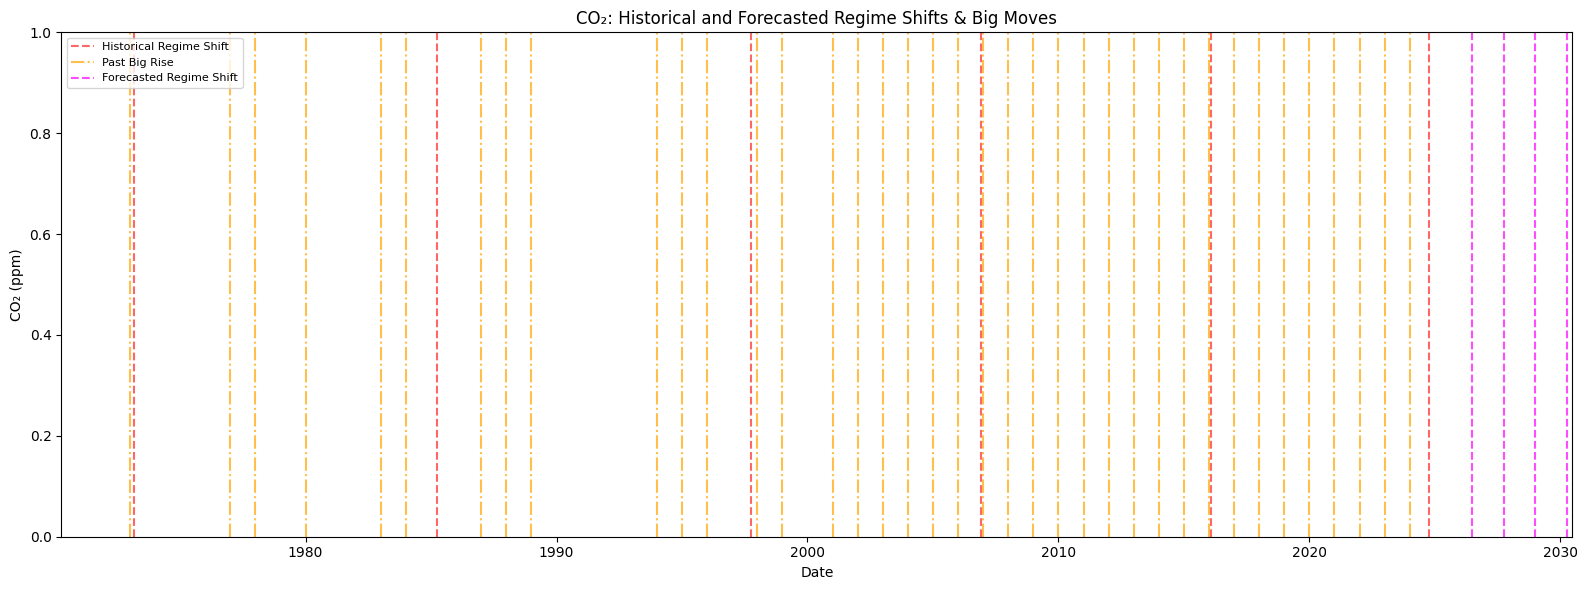

In [ ]:
plt.figure(figsize=(16,6))


for i, date in enumerate(break_dates):
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.6, label='Historical Regime Shift' if i==0 else "")

for year in big_rises.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='orange', linestyle='-.', alpha=0.7, label='Past Big Rise' if year == big_rises.index.year[0] else "")
for year in big_declines.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='blue', linestyle=':', alpha=0.7, label='Past Big Decline' if year == big_declines.index.year[0] else "")

# Forecasted regime shift markers
for i, date in enumerate(forecast_break_dates):
    plt.axvline(x=date, color='magenta', linestyle='--', alpha=0.7, label='Forecasted Regime Shift' if i==0 else "")

for year in forecast_big_rises.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='gold', linestyle='-.', alpha=0.7, label='Future Big Rise' if year == forecast_big_rises.index.year[0] else "")
for year in forecast_big_declines.index.year:
    plt.axvline(x=pd.Timestamp(f'{year}-01-01'), color='cyan', linestyle=':', alpha=0.7, label='Future Big Decline' if year == forecast_big_declines.index.year[0] else "")

plt.title("CO₂: Historical and Forecasted Regime Shifts & Big Moves")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:

all_shifts = pd.DataFrame({
    'Date': [*break_dates, *forecast_break_dates],
    'Type': ['Historical']*len(break_dates) + ['Forecasted']*len(forecast_break_dates)
})
print(all_shifts)


        Date        Type
0 1973-03-01  Historical
1 1985-04-01  Historical
2 1997-10-01  Historical
3 2006-12-01  Historical
4 2016-02-01  Historical
5 2024-10-01  Historical
6 2026-07-01  Forecasted
7 2027-10-01  Forecasted
8 2029-01-01  Forecasted
9 2030-04-01  Forecasted


In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example: prequential evaluation on the last N years (adjust window as you like)
N_years = 10
window_months = 240  # 20 years for initial fit
series = df['co2']

start_idx = len(series) - N_years*12 - 1

# Fit model up to start_idx
arima_model = ARIMA(series.iloc[:start_idx], order=(2,1,2)).fit()
hw_model = ExponentialSmoothing(series.iloc[:start_idx], trend='add', seasonal='add', seasonal_periods=12).fit()

preds_ens, truths, dates = [], [], []

for i in range(start_idx, len(series)-1):
    train_data = series.iloc[max(0, i-window_months):i+1]
    # (Optional: refit models here if you want adaptive retraining)
    arima_pred = arima_model.forecast(steps=1).iloc[0]
    hw_pred = hw_model.forecast(steps=1).iloc[0]
    ensemble_pred = (arima_pred + hw_pred) / 2

    preds_ens.append(ensemble_pred)
    truths.append(series.iloc[i+1])
    dates.append(series.index[i+1])

# Calculate and print error metrics
mae = mean_absolute_error(truths, preds_ens)
rmse = np.sqrt(mean_squared_error(truths, preds_ens))
print(f"Prequential forecast MAE: {mae:.3f} ppm")
print(f"Prequential forecast RMSE: {rmse:.3f} ppm")


Prequential forecast MAE: 11.395 ppm
Prequential forecast RMSE: 13.456 ppm


In [104]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import MonthBegin

# Assume last_regime_start and last_regime_end are already set from previous steps:
# last_regime_start = all_dates[-2]
# last_regime_end = all_dates[-1]
segment_latest = df.loc[last_regime_start:last_regime_end, 'co2']


In [107]:
if len(segment_latest) >= 24:
    hw_model_latest = ExponentialSmoothing(
        segment_latest, trend='add', seasonal='add', seasonal_periods=12
    ).fit()
    hw_forecast_latest = hw_model_latest.forecast(steps=n_forecast)
    hw_forecast_latest.index = future_dates
else:
    print(f"Not enough data in latest regime for seasonal HW: only {len(segment_latest)} months.")


Not enough data in latest regime for seasonal HW: only 1 months.
